# Modeling:


For this section we'll look at physical features in Chicago and what affect they have on crimes. I've collected eight additional data sets from https://data.cityofchicago.org/. After some cleaning, they'll be stripped down into a vectors and used as the input into various machine learning models. The output will be a predicted threat surface of the city.


# Setup and reading in data:

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from datetime import datetime as dt
import seaborn as sns
import math

In [4]:
# "globals" -- bounding edges of crime in Chicago, computed in ChicagoCrimeEDA notebook.
lat_min = 41.644604096
lat_max = 42.022671246
lon_min = -87.928909442 
lon_max = -87.524529378

In [3]:
# Read in new data.
vacant_df = pd.read_csv("data/311_Service_Requests_-_Vacant_and_Abandoned_Buildings_Reported.csv")
health_df = pd.read_csv("data/Chicago_Department_of_Public_Health_Clinic_Locations.csv")
connect_df = pd.read_csv("data/Connect_Chicago_Locations.csv") # internet access
bus_df = pd.read_csv("data/CTA_-_System_Information_-_Bus_Stop_Locations_in_Digital_Sign_Project.csv")
train_df = pd.read_csv("data/CTA_-_System_Information_-_List_of__L__Stops.csv")
farmer_df = pd.read_csv("data/Farmers_Markets_-_2012.csv")
library_df = pd.read_csv("data/Libraries_-_Locations__Hours_and_Contact_Information.csv")
police_df = pd.read_csv("data/Police_Stations_Map.csv")
crime_df = pd.read_csv("data/Chicago_Crimes_2012_to_2017.csv")

/Users/jacob/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (4,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## A little data cleanup:
Focusing just on 2016 to minimize the amount of data to look through. Adding day column to look at specific time spans.

In [5]:
# Crime dataset is quite large, so we'll only focus on last year:
crime_df = crime_df[crime_df["Year"] == 2016]

# Convert the string dates to datetime objects
crime_df["Date"] = pd.to_datetime(crime_df["Date"])

In [8]:
# Let's add a column that is 0-366 range, this will allow us to look at time slices throughout 2016
crime_df["Day"] = crime_df["Date"].apply(lambda x: x.timetuple().tm_yday)

In [6]:
def location_converter(s):
    """Takes a series of points -- tuples (lat, lon) --  as strings and converts them to floats"""
    return s.apply(lambda x: tuple(float(x) for x in x.strip(')(').replace(',','').split()))

# Not all DFs had the same keyname for the lat/lon points. Now they'll all be converted
# in to simple series of tuples. 
vacant_locations = location_converter(vacant_df["Location"].dropna())
health_locations = location_converter(health_df["Location"].dropna())
connect_locations = location_converter(connect_df["Location"].dropna())
bus_locations = location_converter(bus_df["Location"].dropna())
train_locations = location_converter(train_df["Location"].dropna())
farmer_locations = location_converter(farmer_df["Map"].dropna())
library_locations = location_converter(library_df["LOCATION"].dropna())
police_locations = location_converter(police_df["LOCATION"].dropna())

In [9]:
# A randomly chosen week of crime to use as the training/test set:
crime_week_df = crime_df[(crime_df["Day"] >= 100) & (crime_df["Day"] <= 107)]
crime_week_locations = location_converter(crime_week_df["Location"].dropna())

In [10]:
# The following week of crime used for model comparisons.
crime_next_week_df = crime_df[(crime_df["Day"] >= 108) & (crime_df["Day"] <= 114)]
crime_next_week_locations = location_converter(crime_next_week_df["Location"].dropna())

Now that we've read in and cleaned the latitude/longitude data from the datasets, we'll start out by doing a visualization so we can see the geographic points. On top of each point we'll use a gaussian kernel to represent a range of influence that point has on its surroundings.

In [11]:
def make_grid(m1, m2, bandwidth):
    """ Returns a grid of the Chicago area and drops a gaussian curve over points found in m1/m2.
    m1: latitude points
    m2: longitude points
    bandwidth: size of the gaussian used. picked by experiment"""
    
    # mesh grid of values associated with the real (j). The grid is from min to max 
    # with nj being the step size. 
    X, Y = np.mgrid[lat_min:lat_max:200j, lon_min:lon_max:200j] 
    
    positions = np.vstack([X.ravel(), Y.ravel()]) # x row vector on top of y row vector, complete space
    values = np.vstack([m1, m2]) # raw data lat/lon
    kernel = stats.gaussian_kde(values, bw_method=bandwidth)
    Z = np.reshape(kernel(positions).T, X.shape)
    return Z

In [12]:
# Grids for each feature. Could clean it up, put it in a function, but it's only done once...
# 0.26 is the bandwidth of the gaussian dropped in. It's a magic number for now...
vacant_grid = make_grid([lat for lat,_ in vacant_locations], [lon for _,lon in vacant_locations], 0.26)
health_grid = make_grid([lat for lat,_ in health_locations], [lon for _,lon in health_locations], 0.26)
connect_grid = make_grid([lat for lat,_ in connect_locations], [lon for _,lon in connect_locations], 0.26)
bus_grid = make_grid([lat for lat,_ in bus_locations], [lon for _,lon in bus_locations], 0.26)
train_grid = make_grid([lat for lat,_ in train_locations], [lon for _,lon in train_locations], 0.26)
farmer_grid = make_grid([lat for lat,_ in farmer_locations], [lon for _,lon in farmer_locations], 0.26)
library_grid = make_grid([lat for lat,_ in library_locations], [lon for _,lon in library_locations], 0.26)
police_grid = make_grid([lat for lat,_ in police_locations], [lon for _,lon in police_locations], 0.26)
crime_week_grid = make_grid([lat for lat,_ in crime_week_locations], [lon for _,lon in crime_week_locations], 0.26)

In [412]:
crime_next_week_grid = make_grid([lat for lat,_ in crime_next_week_locations], [lon for _,lon in crime_next_week_locations], 0.26)

In [523]:
def plot_grid(grid, locations, title):
    """Plots out a given grid space with markers for locations of interest
    grids: in kde space (as output by make_grid()) 
    locations: lat/lon tuples. 
    """
    fig, ax = plt.subplots()
    ax.imshow(np.rot90(grid), cmap=plt.cm.gist_earth_r, extent=[lat_min, lat_max, lon_min, lon_max])
    ax.plot([lat for lat,_ in locations], [lon for _,lon in locations], 'k.', markersize=3)
    ax.set_xlim([lat_min, lat_max])
    ax.set_ylim([lon_min, lon_max])
    plt.title(title)
    plt.show()

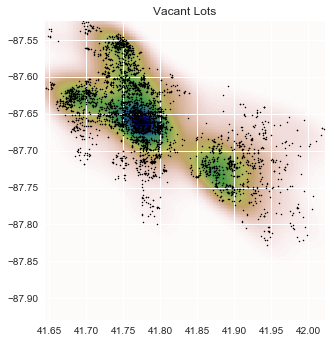

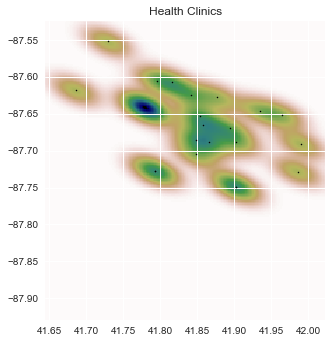

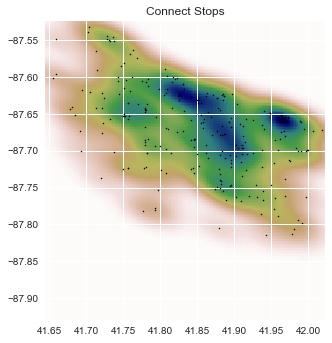

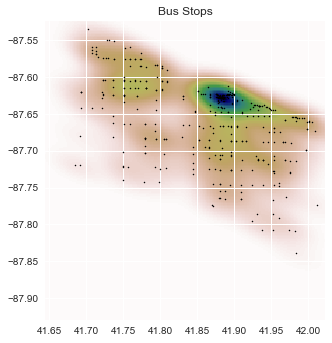

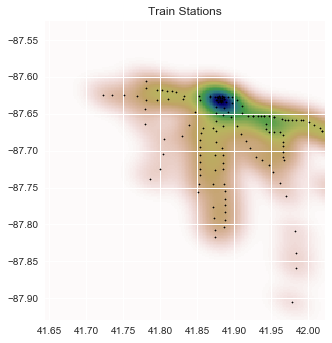

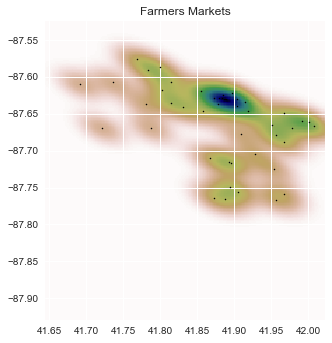

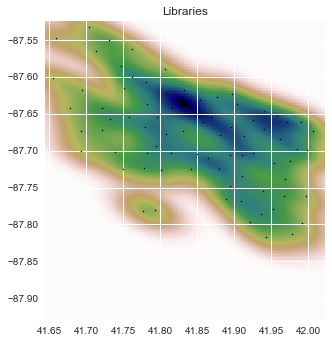

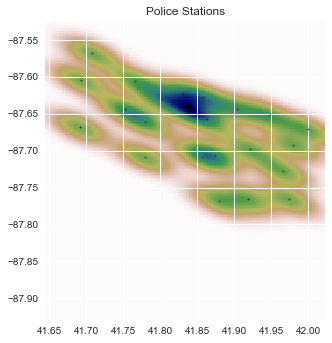

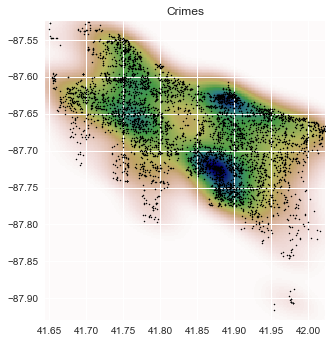

In [525]:
plot_grid(vacant_grid, vacant_locations[:4000], "Vacant Lots") # too many vacant lots to show all, good LABEL
plot_grid(health_grid, health_locations, "Health Clinics")
plot_grid(connect_grid, connect_locations, "Connect Stops")
plot_grid(bus_grid, bus_locations, "Bus Stops")
plot_grid(train_grid, train_locations, "Train Stations")
plot_grid(farmer_grid, farmer_locations, "Farmers Markets")
plot_grid(library_grid, library_locations, "Libraries")
plot_grid(police_grid, police_locations, "Police Stations")
plot_grid(crime_week_grid, crime_week_locations, "Crimes")

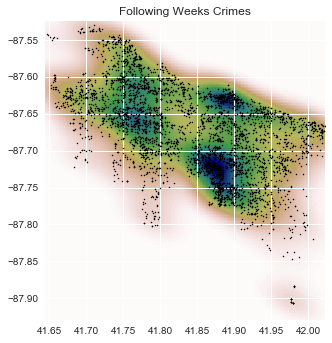

In [526]:
plot_grid(crime_next_week_grid, crime_next_week_locations, "Following Weeks Crimes")

These grids are the first real visual aid we have. Each point corresponds to a real place in Chicago. For instance the Bus Stops grid shows all the routes through the city and gives a nice representation to the true space of the problem (the Chicago city bounds). The coloration gets more intense as individual points begin to overlap, forming an area that is greatly influenced by that point. 

In [12]:
# Turn the above grid spaces into vectors:
vacant_vector = vacant_grid.flatten()
health_vector = health_grid.flatten()
connect_vector = connect_grid.flatten()
bus_vector = bus_grid.flatten()
train_vector = train_grid.flatten()
farmer_vector = farmer_grid.flatten()
library_vector = library_grid.flatten()
police_vector = police_grid.flatten()
crime_week_vector = crime_week_grid.flatten()

# Make a dataframe with the flattened vectors for input to ML algorithms:
grid_df = pd.DataFrame({"Vacant lots" : vacant_vector, "Health clinics" : health_vector, 
                        "Connect hotspots": connect_vector, "Bus stops" : bus_vector, 
                        "Train stops" : train_vector, "Farmers markets": farmer_vector, 
                        "Libraries": library_vector, "Police stations": police_vector})

In [414]:
# To be used as the y values to test how well the model does. 
crime_next_week_vector = crime_next_week_grid.flatten()

Pair wise correalation show how much certain variables explain the data, if two features have a high r2 score they more or less explain the data in the same way. The following plot will show the distribution of values for a given feature as well as its histogram. 

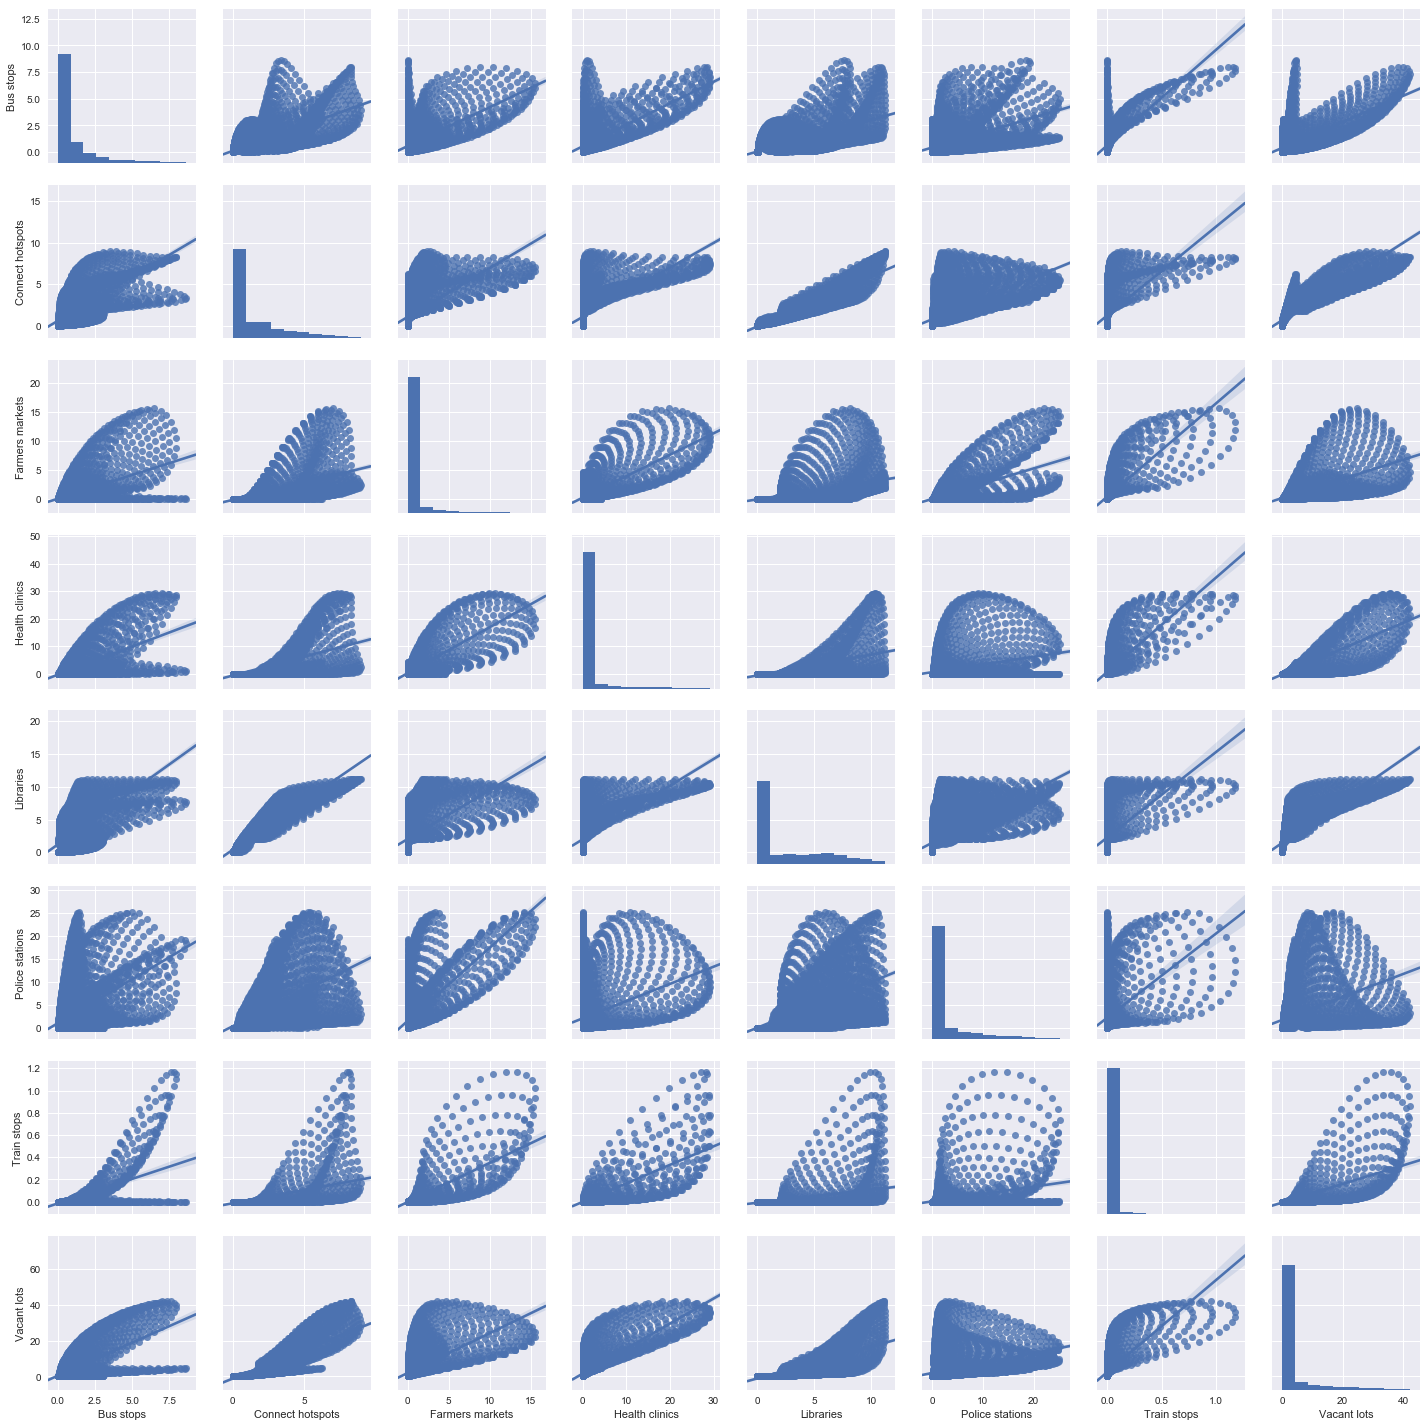

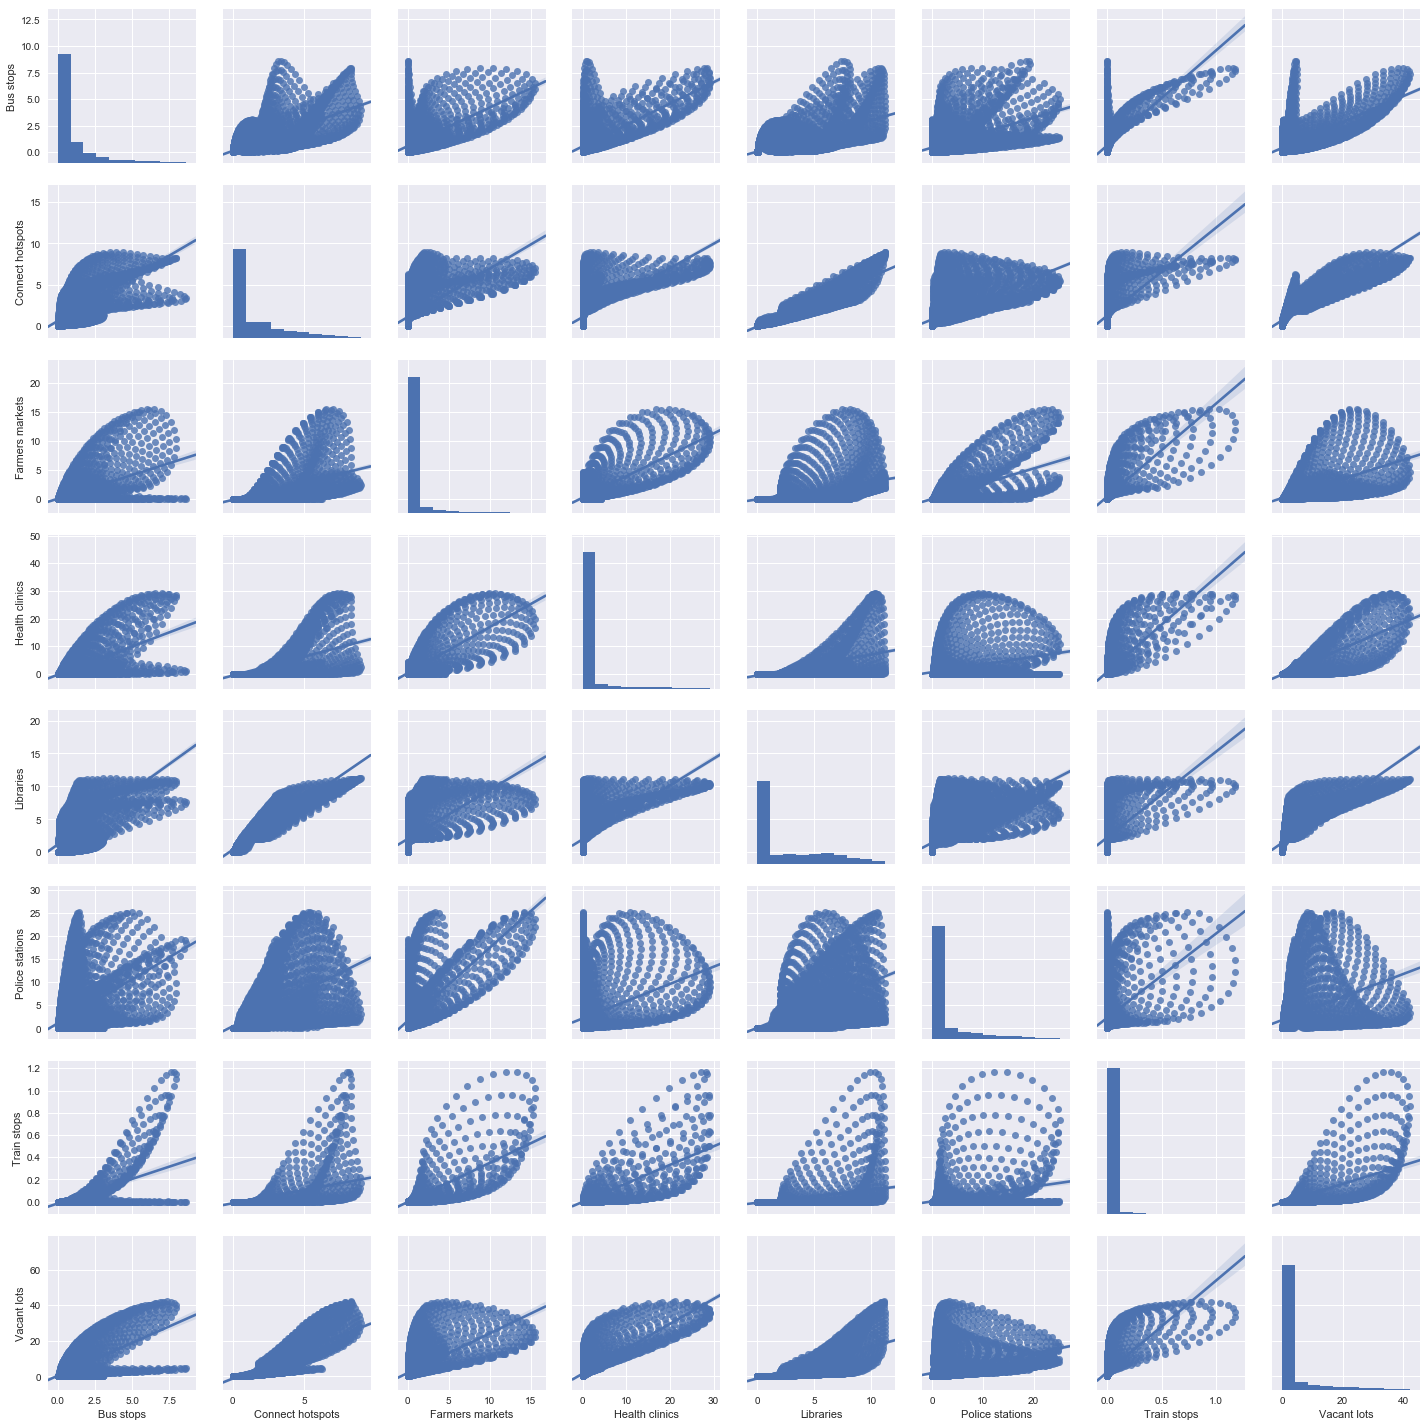

In [508]:
# Only looking at first 10k points to speed up the regressions
g = sns.pairplot(grid_df[:5000], kind="reg")
plt.show(g)

# Fitting models

In [15]:
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix # For comparisons
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [73]:
# Get test and training sets 20% saved for testing:
X_train, X_test, y_train, y_test = train_test_split(grid_df, crime_week_vector, test_size=0.2) 

Let's take a quick look at the distribution of values in our test and training sets and get an intuition about the values we can expect from out models. 

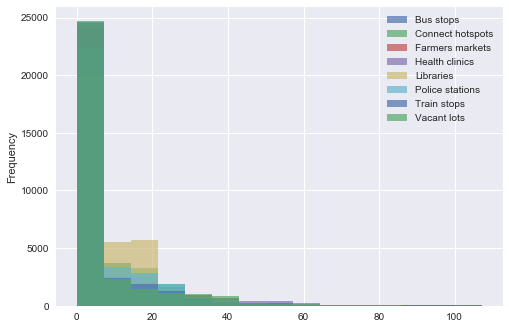

In [529]:
X_train.plot.hist(bins=15, alpha=0.7)
plt.figure(figsize=(16,10))
plt.show()

In [290]:
# Standard deviations for each feature kde vector.
[(x, X_train[x].std()) for x in X_train.columns.values.tolist()]

[('Bus stops', 11.407001566973118),
 ('Connect hotspots', 8.946125737580141),
 ('Farmers markets', 12.941850934870965),
 ('Health clinics', 13.096549514220067),
 ('Libraries', 7.335462123090535),
 ('Police stations', 10.427149077332405),
 ('Train stops', 12.351144009185903),
 ('Vacant lots', 12.516596774825514)]

In [509]:
[(x, X_train[x].mean()) for x in X_train.columns.values.tolist()]

[('Bus stops', 6.395892470403019),
 ('Connect hotspots', 6.396982722660093),
 ('Farmers markets', 6.404197659466144),
 ('Health clinics', 6.494874257388775),
 ('Libraries', 6.315370377661868),
 ('Police stations', 6.41270683778781),
 ('Train stops', 6.03521673155162),
 ('Vacant lots', 6.410776712860347)]

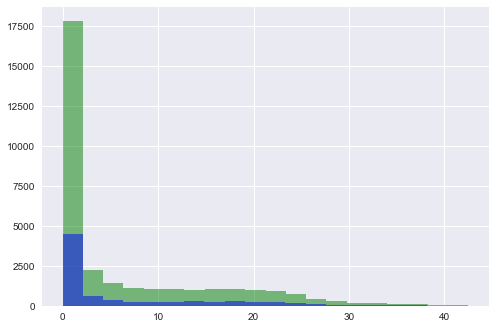

In [277]:
plt.hist(y_train, bins=20, color='green', alpha=0.5)
plt.hist(y_test, bins=20, color='blue', alpha=0.5)
plt.show()

In [510]:
# Standard deviations for the y values of the training and test sets. 
print("y_train standard deviation: {} \ny_test standard deviation:  {}".format(y_train.std(), y_test.std()))

y_train standard deviation: 8.99716939601919 
y_test standard deviation:  9.104145912726779


Keeping the mean and standard deviations as well as the distribution of in mind will be useful when evaluating the predictions given by various models.

## Creating a baseline:
We'll make a baseline for models by performing regression with Police stations as the only feature.

In [513]:
base_linear_reg = LinearRegression()
base_linear_reg.fit(X_train["Police stations"].values.reshape(-1, 1), y_train)

# Perform predictions on test and training set:
base_linear_train_predictions = base_linear_reg.predict(X_train["Police stations"].values.reshape(-1,1))
base_linear_test_predictions = base_linear_reg.predict(X_test["Police stations"].values.reshape(-1,1))

In [516]:
# Training scores and errors:
base_linear_train_score = base_linear_reg.score(X_train["Police stations"].values.reshape(-1, 1), y_train)
base_linear_train_error = mean_squared_error(y_test, base_train_guesses[:len(y_test)])
base_train_r2 = r2_score(y_train[:len(y_test)], base_linear_train_predictions[:len(y_test)])

In [206]:
# Test scores and error:
base_test_predictions = base_linear_reg.predict(X_train["Police stations"].values.reshape(-1, 1))
base_linear_test_score = base_linear_reg.score(X_test["Police stations"].values.reshape(-1, 1), y_test)
base_linear_test_error = mean_squared_error(y_test, base_linear_test_predictions)

In [207]:
print("Base linear training error:      {}".format(base_linear_train_error))
print("Base linear training score(R^2): {}\n".format(base_linear_train_score))
print("Base linear test error:          {}".format(base_linear_test_error))
print("Base linear test score (R^2):    {}".format(base_linear_test_score))

Base linear training error:      131.32602462348515
Base linear training score(R^2): 0.5711973041946486

Base linear test error:          35.688635579769105
Base linear test score (R^2):    0.5694223079864665


In [519]:
print("standard deviations of predictions for training: {}".format(base_linear_train_predictions.std()))
print("standard deviations of predictions for testing:  {}".format(base_linear_test_predictions.std()))

standard deviations of predictions for training: 6.799844352325313
standard deviations of predictions for testing:  6.74096676082803


As a quick check we can compare the standard deviations of the predictions for this model to those of the training set. 

We can simplify the process above by combining all the models error and R^2 scores into one function with a helper function to print out the values. Now after training we'll have access to the various scores as well as the model for further testing. 

In [520]:
def test_model(model, X_train, y_train, X_test, y_test):
    """Prints out a models error and score on the test and training data. 
    Also returns the fitted model so it can be used elsewhere."""
    
    # Fit model and make predictions:
    model.fit(X_train, y_train)
    test_predictions = model.predict(X_test)
    train_predictions = model.predict(X_train)
    
    # Test:
    test_error = mean_squared_error(y_test, test_predictions)
    test_score = model.score(X_test, y_test)
    
    # Train:
    train_error = mean_squared_error(y_train, train_predictions)
    train_score = model.score(X_train, y_train)
    
    # Returns a tuple with models performace scores as well as the model
    return (train_error, train_score, test_error, test_score, model)

def print_model_scores(res):
    """ res in form of: (training_error, training_score, test_error, test_score)"""
    train_e, train_s, test_e, test_s, m = res
    print("Training error:      {}\nTraining score(R^2): {}\n\nTest error:          {}\nTest score (R^2):    {}".format(train_e, train_s, test_e, test_s))

## Linear regression with multiple features:

Now that we have a base line regression with a single feature (Police stations), we can add in the rest of our features and see how the model will change.

In [483]:
linear_multi_res = test_model(LinearRegression(), X_train, y_train, X_test, y_test)
multi_linear_test_error = linear_multi_res[2] # for use later

In [467]:
print_model_scores(linear_multi_res)

Training error:      4.639080683976605
Training score(R^2): 0.9426913561708898

Test error:          4.648656797836151
Test score (R^2):    0.9439146977053399


In [522]:
# Get model for later use
linear_multi_model = linear_multi_res[-1]
#linear_multi_model

In [521]:
linear_predictions.std(), linear_predictions.mean()

(8.8789236019745736, 6.3998775372040893)

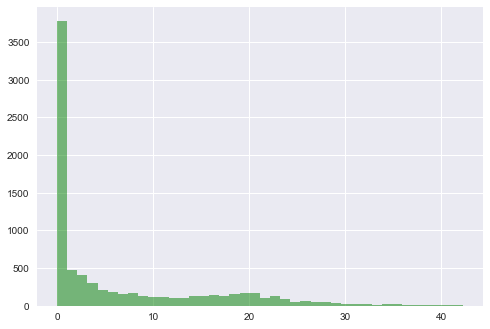

In [301]:
plt.hist(linear_predictions, bins=40, color='green', alpha=0.5)
plt.show()

We've seen a considerable increase in R-squared as well as a solid drop in error. Adding in more data will always help, but we'll look at some more complicated models to see if we can do better. 

## SVM:

In [22]:
from sklearn.svm import SVR

In [421]:
# We'll try SVR with both a linear kernel, and rbf which can generate curved decision boundaries. 
svr = SVR(kernel='linear')
svr_rbf = SVR(kernel='rbf')

In [422]:
# We're using fewer data points from our test/training sets to lighten to the computational load. 
linear_svr_res = test_model(svr, X_train[:1500], y_train[:1500], X_test[:1500], y_test[:1500])
rbf_svr_res = test_model(svr_rbf, X_train[:1500], y_train[:1500], X_test[:1500], y_test[:1500])

In [488]:
# Get the model out for use later:
linear_svr_model = linear_svr_res[-1]
rbf_svr_model = rbf_svr_res[-1]
linear_svr_test_error = linear_svr_res[2]
rbf_svr_test_error = rbf_svr_res[2]
#linear_svr_model, rbf_svr_model

In [423]:
print_model_scores(linear_svr_res)

Training error:      4.876579761371994
Training score(R^2): 0.9421414019315548

Test error:          5.625040584755295
Test score (R^2):    0.9388076272696093


In [424]:
print_model_scores(rbf_svr_res)

Training error:      30.735579135799945
Training score(R^2): 0.635335090034738

Test error:          41.46283213322293
Test score (R^2):    0.5489438626931837


In [305]:
svr_test_predictions.std()

8.9540516058631887

The linear kernel here performs considerably better than rbf and the linear model. Generally with SVM using the linear kernel is suggested when you have more features than observations, and when the number of observations are greater than 50,000.

# KNN:


In [153]:
from sklearn.neighbors import KNeighborsRegressor

In [447]:
neighbors_3 = KNeighborsRegressor(n_neighbors=3) 
neighbors_5 = KNeighborsRegressor(n_neighbors=5) 

In [448]:
neighbors_3_res = test_model(neighbors_3, X_train, y_train, X_test, y_test)
neighbors_5_res = test_model(neighbors_5, X_train, y_train, X_test, y_test)

In [495]:
# Get the model out for testing later:
neighbors_3_model = neighbors_3_res[-1]
neighbors_5_model = neighbors_5_res[-1]
neighbors_3_test_error = neighbors_3_res[2]
neighbors_5_test_error = neighbors_5_res[2]

In [328]:
print_model_scores(neighbors_3_res)

Training error:      0.012780160968080764
Training score(R^2): 0.9998421209410029

Test error:          0.02684301542442325
Test score (R^2):    0.9996761433033131


In [329]:
print_model_scores(neighbors_5_res)

Training error:      0.01515721909762288
Training score(R^2): 0.999812756076068

Test error:          0.02300300928892129
Test score (R^2):    0.9997224723644351


In [162]:
neighbor_regr = neighbors.fit(X_train, y_train)

In [303]:
neighbor_predictions.std()

9.0917476607442325

I think we're beginning to see some overfitting. It's possible that there's soo much overlap in data/features/prediction spaces that we're always finding correlation no matter where we look. This is especially the case when using an algorithm like nearest neighbors. As we look into the prediction space we're pulling true latitude/longitude neighbors which would give the same response. 

similar kernel value in feature space (police station influence effect), likely to pick true lat/lon enighbors which will have similar values in the prediction space the model is giving.  

# Decision Trees:


In [331]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

# Initialize decision tree models of various depths:
tree_reg_2 = DecisionTreeRegressor(max_depth=2)
tree_reg_5 = DecisionTreeRegressor(max_depth=5)
tree_reg_10 = DecisionTreeRegressor(max_depth=10)

In [332]:
tree_reg_2_res = test_model(tree_reg_2, X_train, y_train, X_test, y_test)
tree_reg_5_res = test_model(tree_reg_5, X_train, y_train, X_test, y_test)
tree_reg_10_res = test_model(tree_reg_10, X_train, y_train, X_test, y_test)

In [333]:
print_model_scores(tree_reg_2_res)

Training error:      12.567728217132782
Training score(R^2): 0.8447452180289886

Test error:          13.488717824269573
Test score (R^2):    0.8372607723818905


In [334]:
print_model_scores(tree_reg_5_res)

Training error:      3.903482420320628
Training score(R^2): 0.9517785313603149

Test error:          3.8808841059461394
Test score (R^2):    0.9531777526889386


In [335]:
print_model_scores(tree_reg_10_res)

Training error:      0.446575694040051
Training score(R^2): 0.9944832502092762

Test error:          0.5200730833322628
Test score (R^2):    0.9937254012583628


In [304]:
tree_test_predictions.std()

8.8579886992960031

In [351]:
# Lets perform a little zip magic to group together training/test errors and scores across the different models:
tree_depth = [2,5,10]
z = list(zip(tree_reg_2_res, tree_reg_5_res, tree_reg_10_res))

In [389]:
def plot_error_score(x, x_label, y):
    """Plots error and r-squared values for test and training sets.
    """
    plt.plot(x, y[0])
    plt.xlabel(x_label)
    plt.ylabel("Training Error")
    plt.show()

    plt.plot(x, y[1])
    plt.xlabel(x_label)
    plt.ylabel("Training R-squared")
    plt.show()

    plt.plot(x, y[2])
    plt.xlabel(x_label)
    plt.ylabel("Test Error")
    plt.show()

    plt.plot(x, y[3])
    plt.xlabel(x_label)
    plt.ylabel("Test R-squared")
    plt.show()


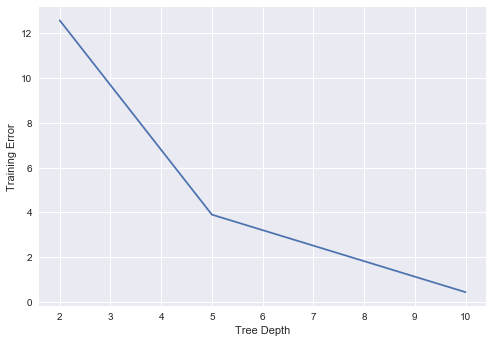

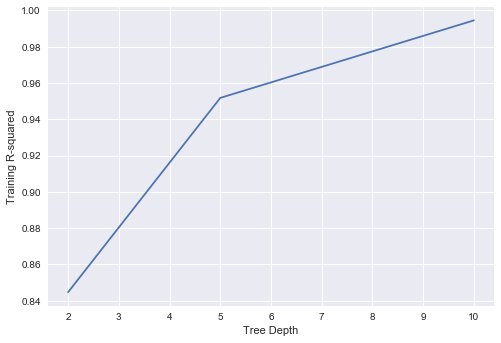

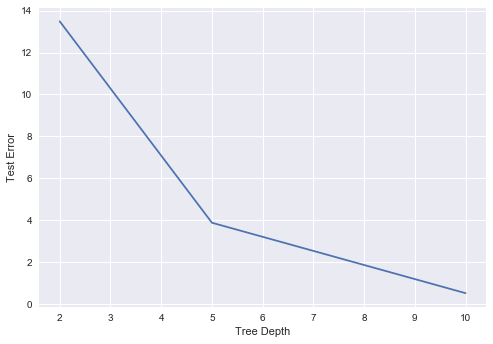

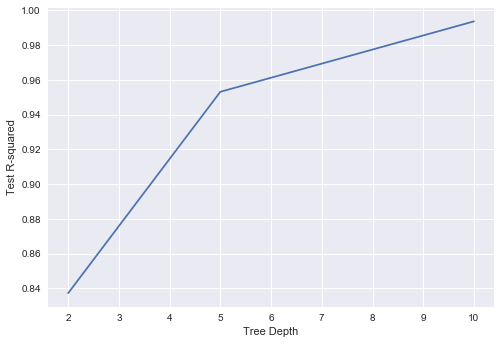

In [390]:
plot_error_score(tree_depth, "Tree Depth",z)

# Boosting:
We'll expect boosting to have better performance than a pure decision tree model as the next learners will oversample the observations that produced high errors in the previous learner.  


In [361]:
from sklearn.ensemble import AdaBoostRegressor

In [359]:
# We'll be testing a variety of boosting models with various depth and estimators to get a sense of the best:
boost_2_20 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=2), n_estimators=20)
boost_2_100 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=2), n_estimators=100)
boost_2_500 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=2), n_estimators=500)

boost_5_20 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=5), n_estimators=20)
boost_5_100 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=5), n_estimators=100)
boost_5_500 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=5), n_estimators=500)

boost_10_20 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=10), n_estimators=20)
boost_10_100 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=10), n_estimators=100)
boost_10_500 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=10), n_estimators=500)

boost_depth_2 = [boost_2_20, boost_2_100, boost_2_500]
boost_depth_5 = [boost_5_20, boost_5_100, boost_5_500]
boost_depth_10 = [boost_10_20, boost_10_100, boost_10_500]

In [425]:
boost_depth_2_res = [test_model(d, X_train, y_train, X_test, y_test) for d in boost_depth_2]
boost_depth_5_res = [test_model(d, X_train, y_train, X_test, y_test) for d in boost_depth_5]
boost_depth_10_res = [test_model(d, X_train, y_train, X_test, y_test) for d in boost_depth_10]

In [499]:
estimator_nums = [20, 100, 500]
boost_model_d_10_e_500 = boost_depth_10_res[-1][-1] # last tuple, last element: 500 estimators, model
boost_model_d_10_e_500_error = boost_depth_10_res[-1][2]

0.12694358471719533

In [428]:
def print_boosting_scores(res, n_estims):
    """res: a list of tuples in the form: [(test error, test score,...)...]
    n_estim: """
    for i, j in zip(res, n_estims):
        print("scores and error with {} estimators".format(j))
        print_model_scores(i)
        print("\n")

In [429]:
print("With a decision tree of depth 2: \n")
print_boosting_scores(boost_depth_2_res, estimator_nums)
print("With a decision tree of depth 5: \n")
print_boosting_scores(boost_depth_5_res, estimator_nums)
print("With a decision tree of depth 10: \n")
print_boosting_scores(boost_depth_10_res, estimator_nums)

With a decision tree of depth 2: 

scores and error with 20 estimators
Training error:      8.283484861103824
Training score(R^2): 0.8976703972387264

Test error:          8.392998036532976
Test score (R^2):    0.8987398182940604


scores and error with 100 estimators
Training error:      16.457890425833888
Training score(R^2): 0.7966882999361539

Test error:          16.445248562229075
Test score (R^2):    0.8015907009197215


scores and error with 500 estimators
Training error:      10.52993146826488
Training score(R^2): 0.8699190350053474

Test error:          10.489569640398393
Test score (R^2):    0.8734450165268215


With a decision tree of depth 5: 

scores and error with 20 estimators
Training error:      1.4803473512006675
Training score(R^2): 0.9817126053904708

Test error:          1.5400983702416375
Test score (R^2):    0.9814189589778445


scores and error with 100 estimators
Training error:      1.5288203061835348
Training score(R^2): 0.9811137972425432

Test error:      

In [382]:
boost_2_zip = list(zip(*boost_depth_2_res))
boost_5_zip = list(zip(*boost_depth_5_res))
boost_10_zip = list(zip(*boost_depth_10_res))

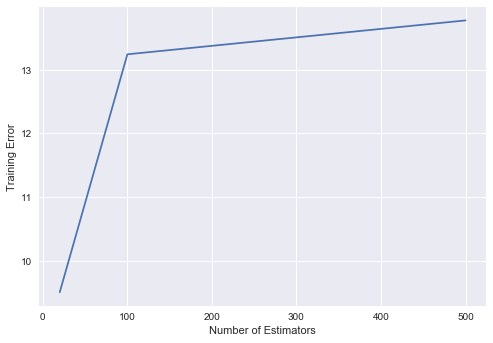

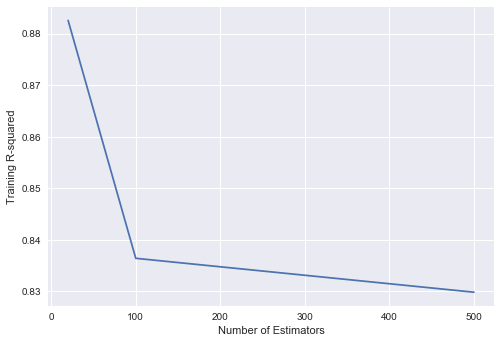

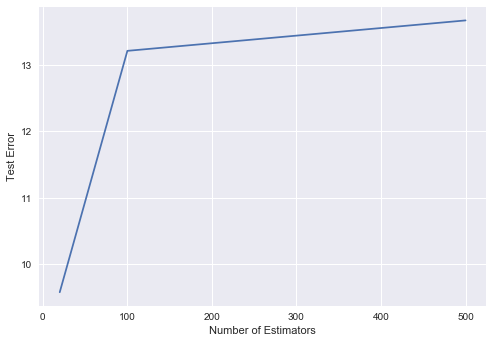

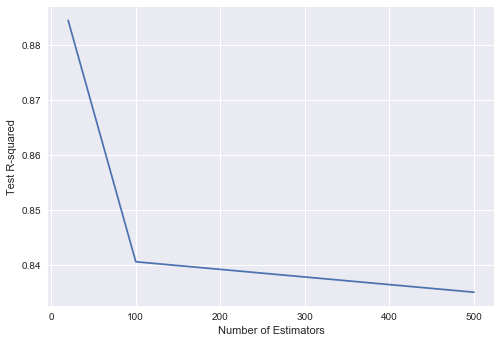

In [393]:
plot_error_score(estimator_nums, "Number of Estimators", boost_2_zip)
# Decision tree with depth of 2

With a depth of 2 for our decision tree regressor, we seem to do worse the more estimators we use.

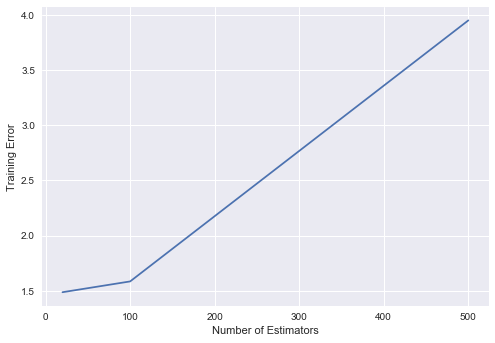

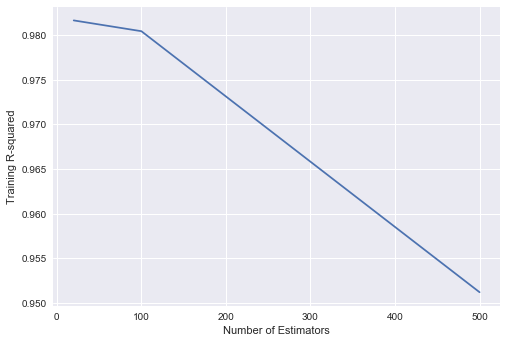

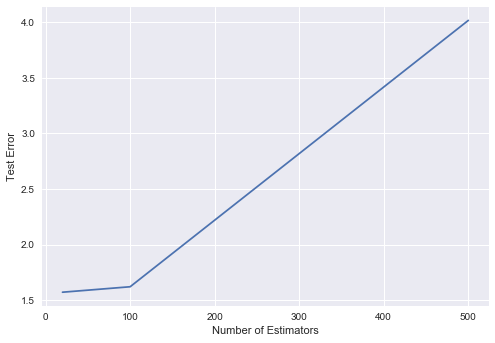

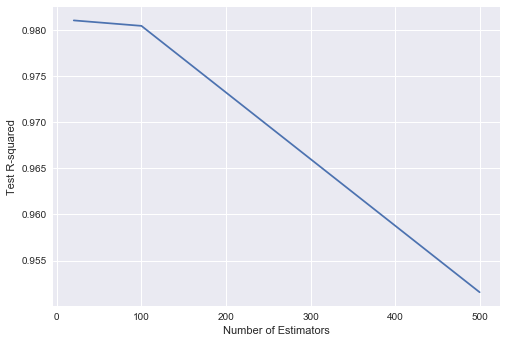

In [394]:
plot_error_score(estimator_nums, "Number of Estimators", boost_5_zip)
# Decision tree with depth of 5:

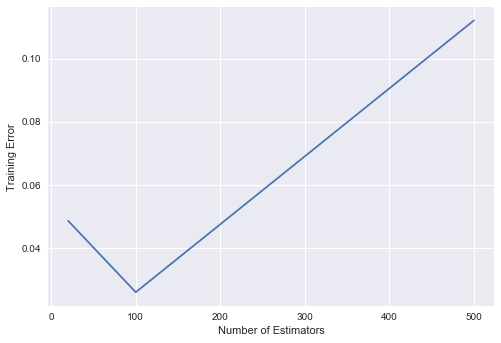

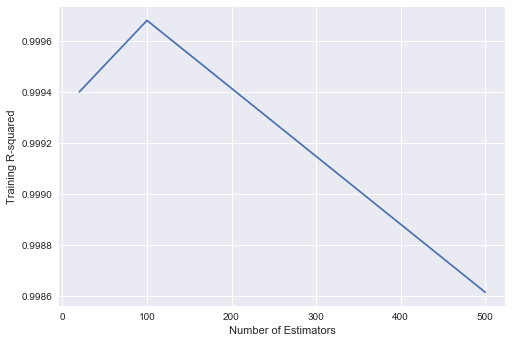

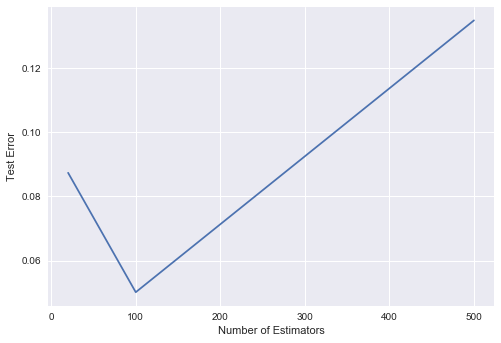

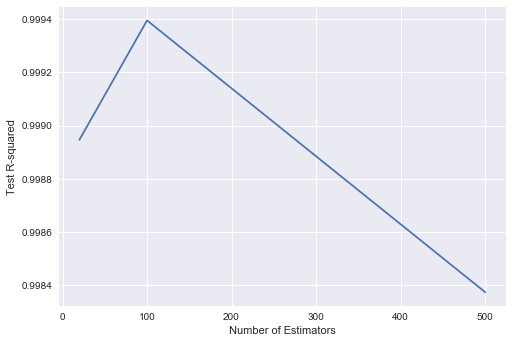

In [395]:
plot_error_score(estimator_nums, "Number of Estimators", boost_10_zip)
# Decision tree with depth of 10

Changing the depth of the original decision tree regressor has the most impact on the boosting algorithm. At a depth of 10 we start to see r-squared values very near to 1 and error scores below 1%.
Using 100 estimators seems to be the best as any more and we tend to see in increase in test error and a decrease in r-squared.

As a whole, I think we're starting to see some issues with our data set. We're getting results that would suggest overfitting. Very low error and very high r-squared values with little variation as the number of estimators grows from 20 to 500 is pretty suspect.

# Predicting next weeks crime:
We've trained and tested quite a few models. The best performing one is an ensemble method using boosting and decision trees with a depth of 10 and 100 estimators. We'll test on the following week of crime (after the test training set) to get an idea of the predictive power these models may have. Also, as I suspect we're already in the realm of overfitting, this will be a good test to see how the error changes. 

We'll start with our base linear model using only police stations.

In [534]:
next_weeks_base_linear_preds = base_linear_reg.predict(X_train["Police stations"].values.reshape(-1, 1))
base_linear_error = mean_squared_error(crime_next_week_vector[:len(next_weeks_base_linear_preds)], next_weeks_base_linear_preds)
print("RMSE for next week: {} ".format(math.sqrt(base_linear_error)))
print("RMSE during test:    {}".format(math.sqrt(base_linear_test_error)))

RMSE for next week: 12.02189633354182 
RMSE during test:    5.9739966169867476


Here we see our base linaer model almost doubles the RMSE value when predicting on the following week of crime. We'll take a look now at our multi feature linear model and see if that performs better on next weeks data. We'll expect to see better performance like we saw during testing.

In [545]:
# We'll make a quick method for convenience.
def next_week_comparison(model, X, prev_error):
    next_preds =  model.predict(X)
    next_weeks_error = mean_squared_error(crime_next_week_vector[:32000], next_preds)
    print("RMSE for next week: {} ".format(math.sqrt(next_weeks_error)))
    print("RMSE during test:    {}".format(math.sqrt(prev_error)))
    return next_preds # for testing

In [546]:
next_week_comparison(linear_multi_model, X_train, multi_linear_test_error)

RMSE for next week: 13.212129195200832 
RMSE during test:    2.156074395246173


array([  0.19862316,  -0.04256811,  -0.03716452, ...,  14.64953098,
         0.67983339,   4.43818215])

We actually see an increase in RMSE when moving from from the single feature to multi feature model.

In [493]:
next_week_comparison(linear_svr_model, X_train, linear_svr_test_error)

RMSE for next week: 13.320019557362137 
RMSE during test:    2.3717168011285192


In [494]:
next_week_comparison(rbf_svr_model, X_train, rbf_svr_test_error)

RMSE for next week: 11.365710523533 
RMSE during test:    6.439163931227635


RBF actually has a little less error on next weeks data. During training and testing we say it have worse performance.

In [496]:
next_week_comparison(neighbors_3_model, X_train, neighbors_3_test_error)

RMSE for next week: 13.393789094630252 
RMSE during test:    0.16383838202455264


In [497]:
next_week_comparison(neighbors_5_model, X_train, neighbors_5_test_error)

RMSE for next week: 13.391054240399106 
RMSE during test:    0.15166742988829635


In [500]:
next_week_comparison(boost_model_d_10_e_500, X_train, boost_model_d_10_e_500_error)

RMSE for next week: 13.28945482968981 
RMSE during test:    0.35629143228148963


# Observations:

We've seen a huge increase in error from the performance of these models on the test/train sets to a previously unseen dataset. 

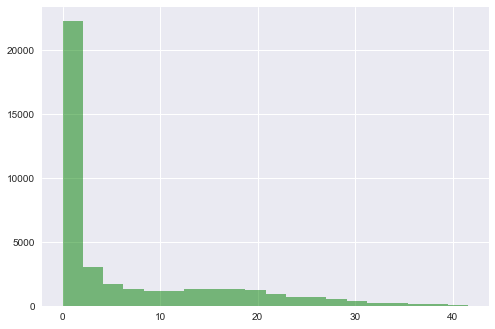

In [540]:
plt.hist(crime_next_week_vector, bins=20, color='green', alpha=0.5) 
#plt.hist(y_test, bins=20, color='blue', alpha=0.5) 
plt.show()

In [541]:
crime_next_week_vector.std()

9.1293015718354784

Similar standard deviation and histogram for the test/train sets, so it's unlikely we got a bad selection when splitting. 

In [543]:
from sklearn.metrics import roc_curve

In [547]:
lin_model_preds = next_week_comparison(linear_multi_model, X_train, multi_linear_test_error)

RMSE for next week: 13.212129195200832 
RMSE during test:    2.156074395246173


In [559]:
# Normalize the data so all values are between 0 and 1 for roc_curve
crime_next_week_norm = np.divide(crime_next_week_vector, np.max(crime_next_week_vector))
lin_model_preds_norm = np.divide(lin_model_preds, np.max(lin_model_preds))

In [569]:
fpr, tpr, thresholds = roc_curve(crime_next_week_norm[:32000], lin_model_preds_norm, pos_label=1)

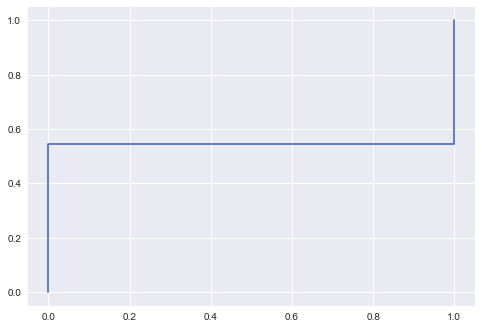

In [570]:
plt.plot(tpr, fpr)
plt.show()

(140,)